In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from pykeops.torch import LazyTensor
import torch

from constants import USE_LATEX, FONTSIZE, LEGEND_SPECS, SZ_COL, SZ_ROW, BASE_SAVE_DIR, EXTENSION
from base_utils import render_in_latex, set_fontsize, get_save_path

In [3]:
# Save the current working directory
original_dir = os.getcwd()

try:
    # Change to the directory containing the module
    new_dir = "../"  # Replace with the actual path
    os.chdir(new_dir)

    # Add the directory to the Python path (if necessary)
    sys.path.append(new_dir)

    # Import the module
    from src.kernels.kernel_inits import _get_kernel
    from src.experiment_utils import set_random_seed

finally:
    # Change back to the original directory
    os.chdir(original_dir)

In [4]:
if USE_LATEX:
    render_in_latex()
set_fontsize(FONTSIZE)

In [5]:
set_random_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
n = 10000
d = 10
lambd_unsc = 1e-6
lambd = n * lambd_unsc

l1laplace_params = {"type": "l1_laplace", "sigma": d ** 0.5}
rbf_params = {"type": "rbf", "sigma": d ** 0.5}
matern52_params = {"type": "matern", "sigma": d ** 0.5, "nu": 5/2}
gammas = [1, 2, 4, 8, 16, 32, 64, 128, 256]

figsize = (SZ_COL, SZ_ROW)
save_dir = os.path.join(BASE_SAVE_DIR, "tail_dim")

In [7]:
X = torch.randn(n, d, device=device)
X1_lazy = LazyTensor(X[:, None, :])
X2_lazy = LazyTensor(X[None, :, :])

In [8]:
l1laplace_kernel = _get_kernel(X1_lazy, X2_lazy, l1laplace_params)
rbf_kernel = _get_kernel(X1_lazy, X2_lazy, rbf_params)
matern52_kernel = _get_kernel(X1_lazy, X2_lazy, matern52_params)

In [9]:
def get_actual_tensor(lazy_tensor, dim, device):
    return lazy_tensor @ torch.eye(dim, device=device)

In [10]:
l1laplace_kernel = get_actual_tensor(l1laplace_kernel, n, device)
rbf_kernel = get_actual_tensor(rbf_kernel, n, device)
matern52_kernel = get_actual_tensor(matern52_kernel, n, device)

In [11]:
l1laplace_eigs = torch.linalg.eigvals(l1laplace_kernel.cpu())
rbf_eigs = torch.linalg.eigvals(rbf_kernel.cpu())
matern52_eigs = torch.linalg.eigvals(matern52_kernel.cpu())

In [12]:
l1laplace_eigs = torch.sort(l1laplace_eigs.real, descending=True)[0]
rbf_eigs = torch.sort(rbf_eigs.real, descending=True)[0]
matern52_eigs = torch.sort(matern52_eigs.real, descending=True)[0]

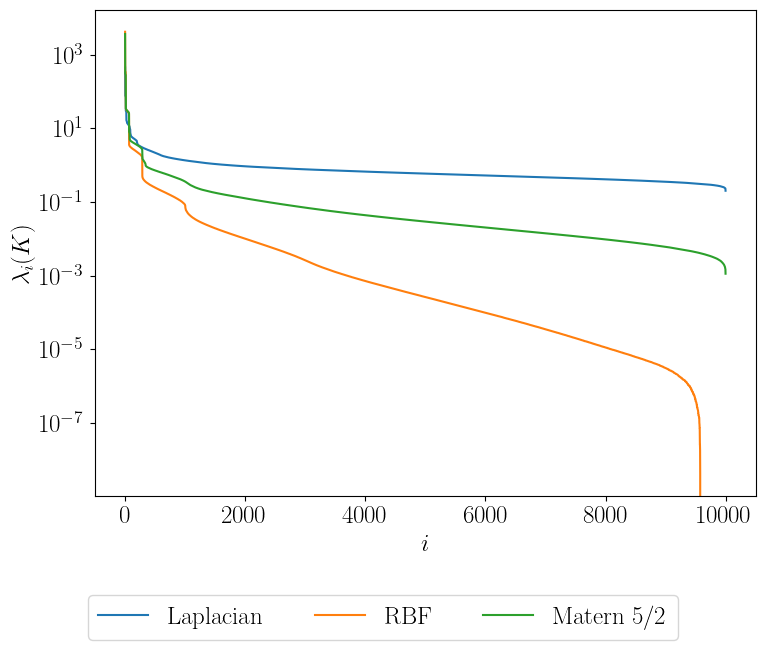

In [55]:
fig, axes = plt.subplots(1, 1, figsize=figsize)
axes.semilogy(l1laplace_eigs.cpu().numpy(), label="Laplacian")
axes.semilogy(rbf_eigs.cpu().numpy(), label="RBF")
axes.semilogy(matern52_eigs.cpu().numpy(), label="Matern 5/2")
axes.set_ylabel(r"$\lambda_i(K)$")
axes.set_xlabel(r"$i$")
fig.legend(**LEGEND_SPECS)
fig.tight_layout()
plt.savefig(get_save_path(save_dir, f"tail_dim.{EXTENSION}"), bbox_inches="tight")

In [56]:
def gamma_lmin_eff_dim(spectrum, gamma, lambd):
    return torch.sum(spectrum / (spectrum + gamma * (lambd + torch.min(spectrum))))

In [57]:
def gamma_flat_dim(spectrum, gamma, lambd):
    return torch.sum(spectrum > gamma * (lambd + torch.min(spectrum)))

In [58]:
l1_laplace_eff_dims = np.array([gamma_lmin_eff_dim(l1laplace_eigs, gamma, lambd) for gamma in gammas])
rbf_eff_dims = np.array([gamma_lmin_eff_dim(rbf_eigs, gamma, lambd) for gamma in gammas])
matern52_eff_dims = np.array([gamma_lmin_eff_dim(matern52_eigs, gamma, lambd) for gamma in gammas])

l1_laplace_flat_dims = np.array([gamma_flat_dim(l1laplace_eigs, gamma, lambd) for gamma in gammas])
rbf_flat_dims = np.array([gamma_flat_dim(rbf_eigs, gamma, lambd) for gamma in gammas])
matern52_flat_dims = np.array([gamma_flat_dim(matern52_eigs, gamma, lambd) for gamma in gammas])

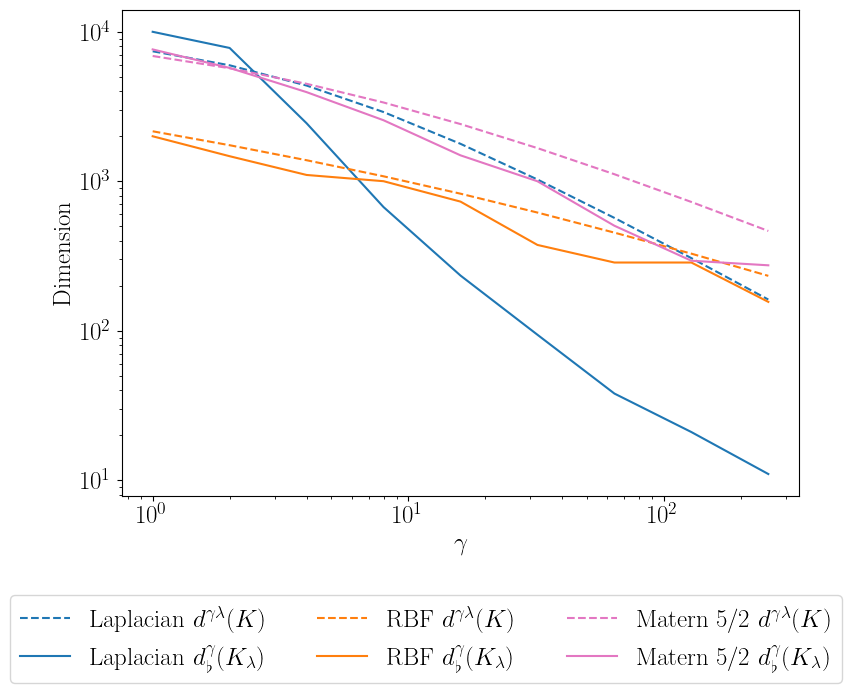

In [59]:
fig, axes = plt.subplots(1, 1, figsize=figsize)
axes.semilogy(gammas, l1_laplace_eff_dims, label=r"Laplacian $d^{\gamma \lambda}(K)$", linestyle="dashed", color="tab:blue")
axes.semilogy(gammas, l1_laplace_flat_dims, label=r"Laplacian $d_\flat^\gamma(K_{\lambda})$", linestyle="solid", color="tab:blue")
axes.semilogy(gammas, rbf_eff_dims, label=r"RBF $d^{\gamma \lambda}(K)$", linestyle="dashed", color="tab:orange")
axes.semilogy(gammas, rbf_flat_dims, label=r"RBF $d_\flat^\gamma(K_{\lambda})$", linestyle="solid", color="tab:orange")
axes.semilogy(gammas, matern52_eff_dims, label=r"Matern 5/2 $d^{\gamma \lambda}(K)$", linestyle="dashed", color="tab:pink")
axes.semilogy(gammas, matern52_flat_dims, label=r"Matern 5/2 $d_\flat^\gamma(K_{\lambda})$", linestyle="solid", color="tab:pink")
axes.semilogx()
axes.set_xlabel(r"$\gamma$")
axes.set_ylabel(r"Dimension")
fig.legend(**LEGEND_SPECS)
fig.tight_layout()
plt.savefig(get_save_path(save_dir, f"dimensions.{EXTENSION}"), bbox_inches="tight")

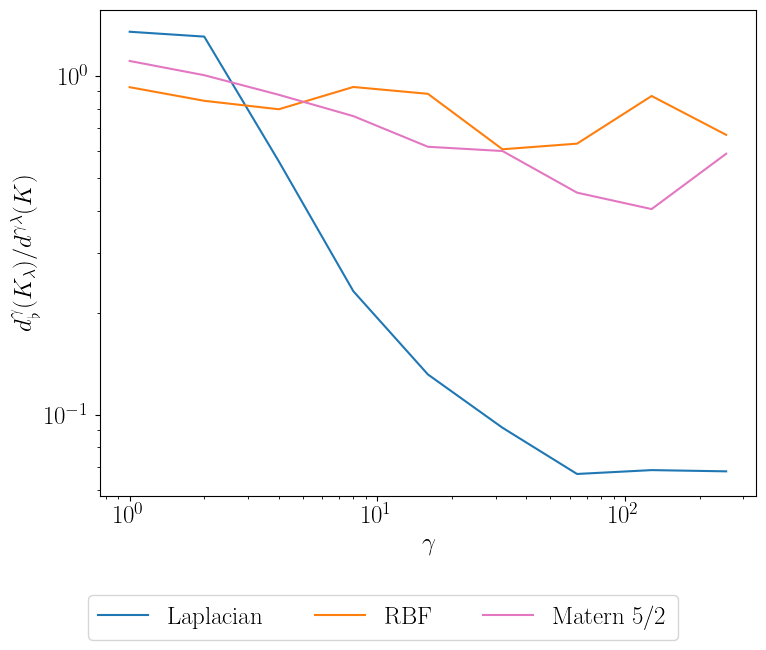

In [60]:
fig, axes = plt.subplots(1, 1, figsize=figsize)
axes.semilogy(gammas, l1_laplace_flat_dims / l1_laplace_eff_dims, label="Laplacian", linestyle="solid", color="tab:blue")
axes.semilogy(gammas, rbf_flat_dims / rbf_eff_dims, label="RBF", linestyle="solid", color="tab:orange")
axes.semilogy(gammas, matern52_flat_dims / matern52_eff_dims, label="Matern 5/2", linestyle="solid", color="tab:pink")
axes.semilogx()
axes.set_xlabel(r"$\gamma$")
axes.set_ylabel(r"$d_\flat^\gamma(K_{\lambda}) / d^{\gamma \lambda}(K)$")
fig.legend(**LEGEND_SPECS)
fig.tight_layout()
plt.savefig(get_save_path(save_dir, f"dimension_ratio.{EXTENSION}"), bbox_inches="tight")